In [6]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf
import pandas as pd
import sys


## 1. Compare reconstruction

## 1. load training data 

In [7]:
FILENAME = './tw_train.npz'
MODEL_LIST= ['DEEPONET-16', 'NIF-small']

data = np.load(FILENAME)['data']
mean = np.load(FILENAME)['mean']
std = np.load(FILENAME)['std']

# using only the normalized data
data_raw = data # visualize the normalized data, how it works

## Before everything.. give POD a shot..

In [8]:
X_matrix = data_raw[:,-1].reshape(20,300)

U,S,VT = np.linalg.svd(X_matrix)

# RANK = 5
NX = 300
NT = 20    
    
def plot_svd_approx(RANK):
    X_reduced = U[:,:RANK]@np.diag(S[:RANK])@VT[:RANK,:]

    # visualization
    x = np.linspace(0,1,NX,endpoint=False)
    t = np.linspace(0,70,NT,endpoint=False)

    fig,axs = plt.subplots(1,2,figsize=(12,4))
    for i in range(0,20,4):
        axs[0].plot(x,X_reduced[i,:],'-',label=str(i) + '-th time')
    for i in range(0,20,4):
        axs[1].plot(x,X_matrix[i,:],'-',label=str(i) + '-th time')
    axs[0].set_title('rank '+str(RANK) + ' approximation')
    axs[1].set_title('truth')


## 2. load models

In [9]:
CASE_PATH = '.'

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def compute_error_across_all_nu(MODEL):

    sess = tf.Session(graph=tf.Graph())
    model_dir = CASE_PATH + '/' + MODEL + '/saved_model_ckpt_800000'
    MODEL_LOADED=tf.saved_model.loader.load(sess, ["serve"], model_dir)
        
    graph = sess.graph

    # load input tensors
    INPUT_T = graph.get_tensor_by_name('input_T:0')
    # INPUT_NU = graph.get_tensor_by_name('input_NU:0')
    INPUT_X = graph.get_tensor_by_name('input_X:0')

    # ouput tensor
    OUTPUT_U = graph.get_tensor_by_name('output_u:0')

    
    ## evaluate training error
    PRED_U_LIST = []
    TRUE_U_LIST = []
    NU_LIST = []
    N_TRAIN = 1
    for j in range(N_TRAIN):
        print(j)
        # evaluate on the training data
        input_arr_t = data_raw[20000*j:20000*(j+1),1].reshape(-1,1)
        input_arr_x = data_raw[20000*j:20000*(j+1),0].reshape(-1,1)
        output_arr_u = sess.run(OUTPUT_U, feed_dict={INPUT_T:input_arr_t, INPUT_X:input_arr_x })
        true_arr_u = data_raw[20000*j:20000*(j+1),2].reshape(-1,1)
        
        PRED_U_LIST.append(output_arr_u)
        TRUE_U_LIST.append(true_arr_u)
        # NU_LIST.append(input_arr_nu[0])

        # un-normalized target
        output_arr_u = output_arr_u*std[-1] + mean[-1]
        true_arr_u = true_arr_u*std[-1] + mean[-1]

    return output_arr_u, true_arr_u # mean_err_tr, std_err_tr, 

true_list = []
pred_list = []
for MODEL in MODEL_LIST:
    print('')
    print('==================')
    print('model = ', MODEL)
    print('==================')
    output_arr_u, true_arr_u = compute_error_across_all_nu(MODEL)  
    
    true_list.append(true_arr_u.reshape(NT,NX))
    pred_list.append(output_arr_u.reshape(NT,NX))


model =  DEEPONET-16
INFO:tensorflow:Restoring parameters from ./DEEPONET-16/saved_model_ckpt_800000/variables/variables
0

model =  NIF-small
INFO:tensorflow:Restoring parameters from ./NIF-small/saved_model_ckpt_800000/variables/variables
0


# comparison 

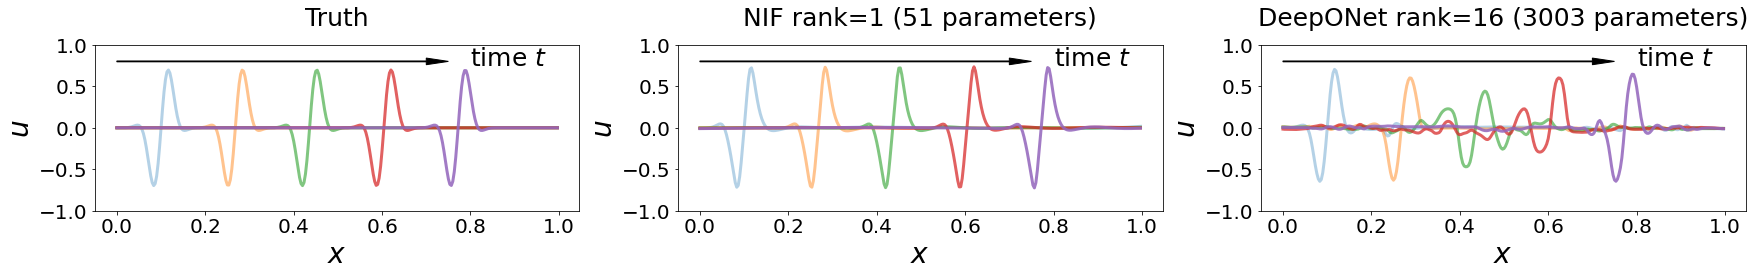

In [14]:
pred_nif_small = pred_list[1] # NIF-small
pred_deeponet_16 = pred_list[0] # DeepONet-16

X_matrix_raw = X_matrix*std[-1] + mean[-1]
# X_reduced = U[:,:RANK]@np.diag(S[:RANK])@VT[:RANK,:]

# visualization
x = np.linspace(0,1,NX,endpoint=False)
t = np.linspace(0,70,NT,endpoint=False)

fig,axs = plt.subplots(1,3,figsize=(25,4))
for i in range(0,20,4):
    axs[2].plot(x,pred_deeponet_16[i,:],'-',label=str(i) + '-th time',alpha=(i+10)/30.,lw=3)
    axs[1].plot(x,pred_nif_small[i,:],'-',label=str(i) + '-th time',alpha=(i+10)/30.,lw=3)
    axs[0].plot(x,X_matrix_raw[i,:],'-',label=str(i) + '-th time',alpha=(i+10)/30.,lw=3)
    
axs[1].set_title('NIF rank=1 (51 parameters)',fontsize=25,y=1.08)
axs[2].set_title('DeepONet rank=16 (3003 parameters)',fontsize=25,y=1.08)
axs[0].set_title('Truth',fontsize=25,y=1.08)
for i in range(3):
    axs[i].set_ylim([-1,1])
    axs[i].set_xlabel(r'$x$',fontsize=28)
    axs[i].set_ylabel(r'$u$',fontsize=28)
    # axs[i].set_yticks([-1,-0.5,0,0.5,1])

    axs[i].arrow(0,0.8,0.7,0,head_width=0.08,head_length=0.05,width=0.01,color='k')
    axs[i].text(0.8,0.75,r'time $t$',fontsize=25)
    axs[i].tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout()
plt.savefig('compare_nif_deeponet.png',bbox_inches='tight')

# compare error 

In [19]:
print("error NIF ",np.linalg.norm(pred_nif_small - X_matrix_raw)**2)
print("error deeponet", np.linalg.norm(pred_deeponet_16 - X_matrix_raw)**2)

error NIF  0.5327563978658976
error deeponet 11.15203289586295


## Draw error

Text(0.5, 1.0, 'error deeponet')

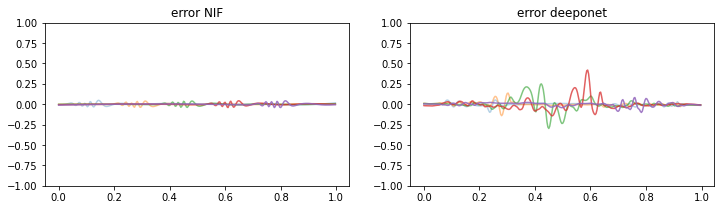

In [25]:
fig,axs = plt.subplots(1,2,figsize=(12,3))
for i in range(0,20,4):
    axs[0].plot(x,pred_nif_small[i,:]-X_matrix_raw[i,:],'-',label=str(i) + '-th time',alpha=(i+10)/30.)
    axs[1].plot(x,pred_deeponet_16[i,:]-X_matrix_raw[i,:],'-',label=str(i) + '-th time',alpha=(i+10)/30.)
    
axs[0].set_ylim([-1,1])
axs[1].set_ylim([-1,1])
axs[0].set_title('error NIF')
axs[1].set_title('error deeponet')